In [1]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import seaborn as sns
import re
from statsmodels.formula.api import ols
from scipy import stats

In [2]:
df = pd.read_csv('test.csv')

### Clean data

In [3]:
def strtolistc(val):
    """Convert string to list of floats"""
    ls = val.strip('[] ').split(',')
    new = []
    for v in ls:
        new.append(float(v))
    return(np.array(new))
def strtolist(val):
    """Convert string to list of floats"""
    ls = val.strip('[] ').split(' ')
    ls = [i.strip(',') for i in ls if i != '']
    new = []
    for v in ls:
        new.append(float(v))
    return(np.array(new))
def strtolists(val):
    """Convert string to list of floats"""
    ls = val.strip('[] ').split(', ')
    new = []
    for v in ls:
        new.append(v.strip('"" '))
    return(new)

In [4]:
df['alphaA'] = df['alphaA'].apply(strtolist)
df['betaA'] = df['betaA'].apply(strtolist)
df['alphaB'] = df['alphaB'].apply(strtolist)
df['betaB'] = df['betaB'].apply(strtolist)
df['choices'] = df['choices'].apply(strtolists)

In [5]:
"""Credence/expected bias for each coin"""
df['EA'] = df['alphaA']/(df['alphaA'] + df['betaA'])
df['EB'] = df['alphaB']/(df['alphaB'] + df['betaB'])

In [6]:
"""Whether agents correctly judge coin B as having higher expected payoff"""
df['correct'] = df['EB'] - df['EA']
df['correct'] = df['correct'].map(lambda x: np.where(x > 0, 1, 0))

In [7]:
"""Brier score for each coin bias estimation"""
df['BrierA'] = (df['EA'] - 0.5)**2
df['BrierB'] = (df['EB'] - (0.5 + df['epsilon']))**2

In [8]:
"""Group performance"""
df['true_converg'] = df['correct'].map(lambda x: sum(x)) # Number of successful individuals
df['avgBrierA'] = df['BrierA'].map(lambda x: sum(x)/len(x))
df['avgBrierB'] = df['BrierB'].map(lambda x: sum(x)/len(x))
df['avgBrier'] = (df['avgBrierA'] + df['avgBrierB'])/2 # Average Brier of the group

In [9]:
df['B'] = df['choices'].map(lambda x: x.count("'B'"))

#### Summary statistics

In [18]:
n_total = 10
cols = ['k', 'w', 'epsilon', 'div', 'true', 'false', 'no']
summary = pd.DataFrame(columns=cols) # Summary of convergence rates (based on credences)

for k in [0, 0.01, 0.02, 0.05, 0.1]:
    for w in [0, 0.005, 0.0125, 0.1, 0.5, 1]:
        for e in [0.001]:         
            sub = df[((df['k']==k)&(df['w']==w))&(df['epsilon']==e)]
            for div in [0.5, 0.7, 0.9, 1]:
                divsub = sub[sub['div']==div]['true_converg']
                if len(divsub) > 0:
                    l = len(divsub)
                    true = 0
                    false = 0
                    no = 0
                    for i in divsub:
                        if i==n_total: # True convergence (all choose B)
                            true += 1
                        elif i==0: # False convergence (all choose A)
                            false += 1
                        else: # No convergence/polarization
                            no += 1
                    summary = summary.append(pd.DataFrame([[k, w, e, div, 
                                                            true/l, false/l, no/l]], 
                                                          columns=cols), ignore_index=True)

#### 2(a) in F&S - Replicates (for 10 agents per group)

In [19]:
summary[(summary['div']==0.5)&(summary['k']==0)]

,k,w,epsilon,div,true,false,no
0,0,0,0.001,0.5,0.388764,0.148315,0.462921
3,0,0.005,0.001,0.5,0.541573,0.177528,0.280899
6,0,0.0125,0.001,0.5,0.725843,0.143820,0.130337
9,0,0.1,0.001,0.5,0.738717,0.261283,0.000000
12,0,0.5,0.001,0.5,0.617577,0.382423,0.000000
15,0,1,0.001,0.5,0.632775,0.367225,0.000000


#### 2(b) in F&S - Roughly replicates the shape, but not the order for w >= 0.1

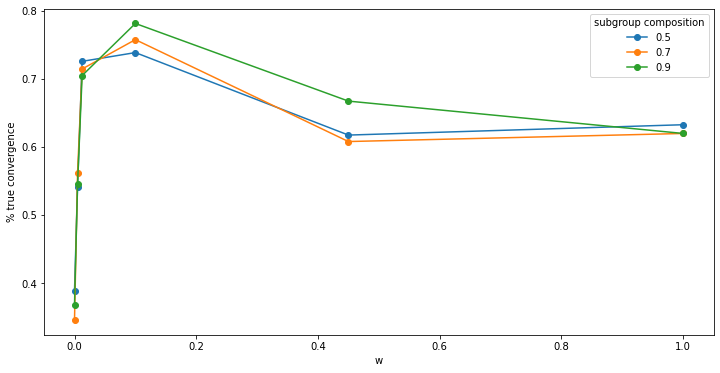

In [16]:
fig, ax = plt.subplots(figsize=(12, 6))
W = [0, 0.005, 0.0125, 0.1, 0.45, 1]
k = 0
e = 0.001
Div = [0.5, 0.7, 0.9]

for d in Div:
    sub = summary[(summary['div']==d)&(summary['k']==k)]
    data = list(sub['true'])
    ax.plot(W, data, label=d, marker='o')
plt.xlabel('w')
plt.ylabel('% true convergence')
plt.legend(title='subgroup composition')

#### 4(a) in F&S - Does not replicate at all. Very far off.

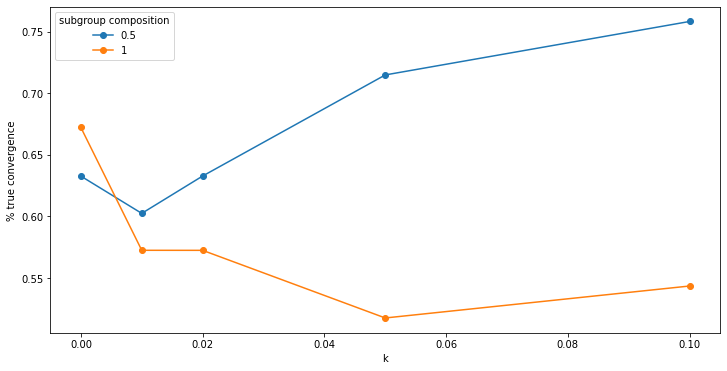

In [17]:
fig, ax = plt.subplots(figsize=(12, 6))
K = [0, 0.01, 0.02, 0.05, 0.1]
w = 1
e = 0.001
Div = [0.5, 1]

for d in Div:
    sub = summary[(summary['div']==d)&(summary['w']==w)]
    data = list(sub['true'])
    ax.plot(K, data, label=d, marker='o')
plt.xlabel('k')
plt.ylabel('% true convergence')
plt.legend(title='subgroup composition')

## Ignore below. Plots for previous datasets

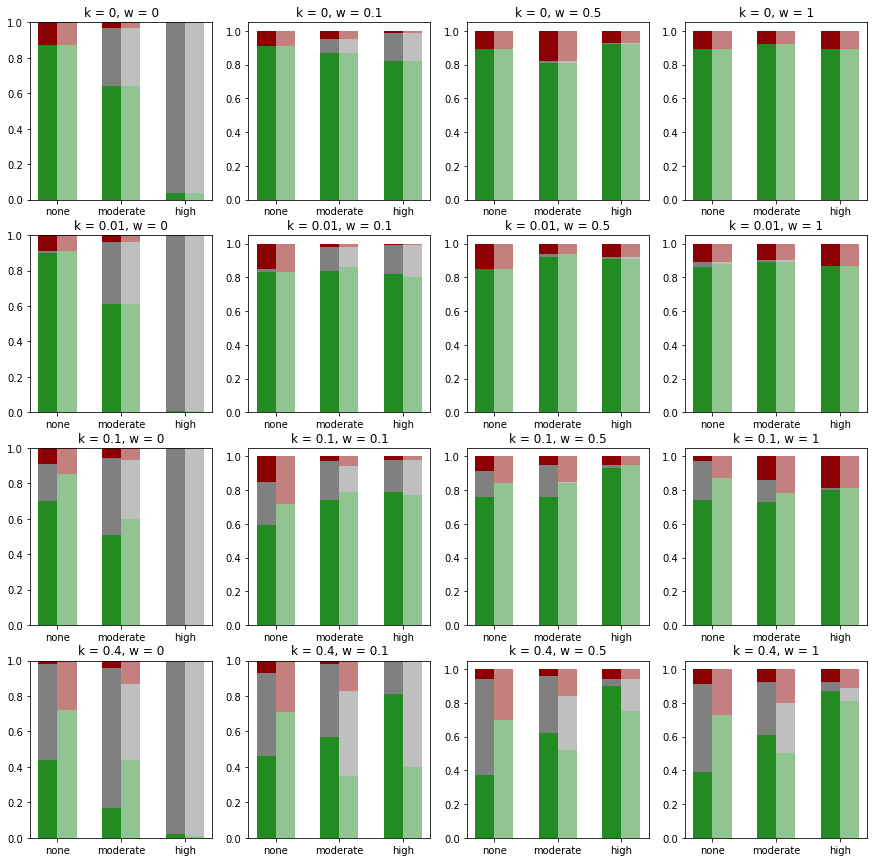

In [13]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
K = [0, 0.01, 0.1, 0.4]
W = [0, 0.1, 0.5, 1]
Div = np.array([1, 0.5, 0])
Div_labels = ['none', 'moderate', 'high']
e = 0.1
width = 0.15
colors = ['forestgreen', 'gray', 'darkred']

for i in range(len(K)):
    for j in range(len(W)):
        k = K[i]
        w = W[j]
        sub = summary[((summary['k']==k)&(summary['w']==w))&(summary['epsilon']==e)]
        if len(sub)>0:
            results = dict()
            for div in Div:
                results['true'] = np.array(sub['true'])
                results['no'] = np.array(sub['no'])
                results['false'] = np.array(sub['false'])
            bottom = np.zeros(len(Div))
            c_idx = 0
            for result, count in results.items():
                axs[i, j].bar(Div, count, width, label=result, bottom=bottom, color=colors[c_idx])
                c_idx += 1
                bottom = np.sum([bottom, count], axis=0)

            subp = public[((public['k']==k)&(public['w']==w))&(public['epsilon']==e)]
            results = dict()
            for div in Div:
                results['true'] = np.array(subp['true'])
                results['no'] = np.array(subp['no'])
                results['false'] = np.array(subp['false'])
            bottom = np.zeros(len(Div))
            c_idx = 0
            for result, count in results.items():
                axs[i, j].bar(Div+width, count, width, label=result, bottom=bottom, 
                              color=colors[c_idx], alpha=0.5)
                axs[i, j].set_xticks(np.flip(Div)+width/2)
                axs[i, j].set_xticklabels(Div_labels)
                c_idx += 1
                bottom = np.sum([bottom, count], axis=0)

            axs[i, j].set_title('k = '+str(k)+', w = '+str(w))
        
# plt.savefig('graphs/FSbyconvergence.png', dpi=200, bbox_inches='tight')

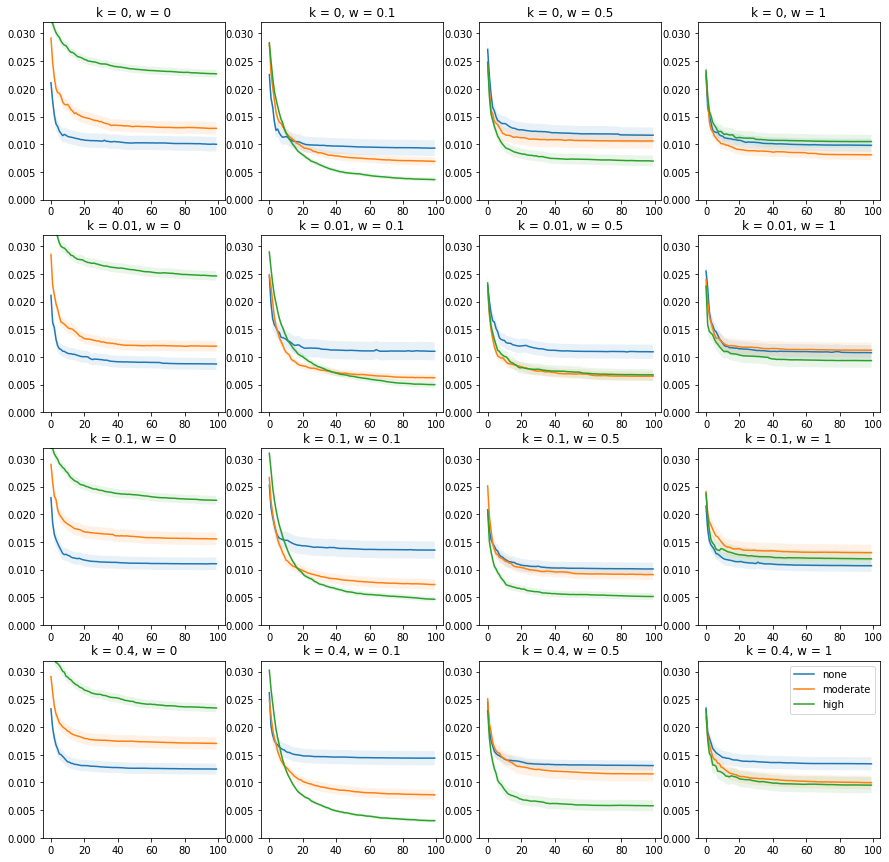

In [14]:
fig, axs = plt.subplots(4, 4, figsize=(15, 15))
e = 0.1

for i in range(len(K)):
    for j in range(len(W)):
        k = K[i]
        w = W[j]
        sub = df[(((df['k']==k)&(df['w']==w))&(df['epsilon']==e))]
        for l in range(len(Div)):
            div = Div[l]
            mean = []
            sem = []
            for t in range(max_time):
                mean.append(sub[(sub['div']==div) & (sub['time']==t)]['avgBrier'].mean())
                sem.append(sub[(sub['div']==div) & (sub['time']==t)]['avgBrier'].sem())
            mean = np.array(mean)
            sem = np.array(sem)
            axs[i, j].plot(range(max_time), mean, label=Div_labels[l])
            axs[i, j].fill_between(range(max_time), 
                    mean-sem, 
                    mean+sem, 
                    alpha=0.1)
            axs[i, j].set_ylim(0, 0.032)
            axs[i, j].set_title('k = '+str(k)+', w = '+str(w))
plt.legend()

# plt.savefig('graphs/FSbyaccuracy.png', dpi=200, bbox_inches='tight')

In [24]:
# slope, intercept, r_value, p_value, std_err = stats.linregress(r[c], r[acc])
cols = ['k', 'w', 'epsilon', 'r', 'p']
R_true = pd.DataFrame(columns=cols)
E = [0.001, 0.01, 0.1]

for i in range(len(K)):
    for j in range(len(W)):
        for m in range(len(E)):
            k = K[i]
            w = W[j]
            e = E[m]
            sub = df[(((df['k']==k)&(df['w']==w))&(df['epsilon']==e))&(df['time']==(max_time-1))]
            slope, intercept, r_value, p_value, std_err = stats.linregress(-sub['div'], sub['true_converg'])
            R_true = R_true.append(pd.DataFrame([[k, w, e, r_value, p_value]], 
                                                      columns=cols), ignore_index=True)

([<matplotlib.axis.XTick at 0x19df2ae80>,
 [Text(0, 0, '0'), Text(1, 0, '0.01'), Text(2, 0, '0.1'), Text(3, 0, '0.4')])

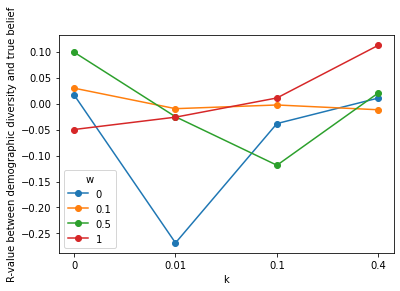

In [25]:
fig, ax = plt.subplots()
K = [0, 0.01, 0.1, 0.4]
e = 0.01

for w in W:
    sub = R_true[(R_true['w']==w)&(R_true['epsilon']==e)]
    data = list(sub['r'])
    ax.plot(data, label=w, marker='o')
plt.xlabel('k')
plt.ylabel('R-value between demographic diversity and true belief')
plt.legend(title='w')
plt.xticks(range(len(K)), K)

In [26]:
# slope, intercept, r_value, p_value, std_err = stats.linregress(r[c], r[acc])
cols = ['k', 'w', 'epsilon', 'r', 'p']
Brier = pd.DataFrame(columns=cols)
E = [0.001, 0.01, 0.1]

for i in range(len(K)):
    for j in range(len(W)):
        for m in range(len(E)):
            k = K[i]
            w = W[j]
            e = E[m]
            sub = df[(((df['k']==k)&(df['w']==w))&(df['epsilon']==e))&(df['time']==(max_time-1))]
            slope, intercept, r_value, p_value, std_err = stats.linregress(sub['div'], sub['avgBrier'])
            Brier = Brier.append(pd.DataFrame([[k, w, e, r_value, p_value]], 
                                                      columns=cols), ignore_index=True)

([<matplotlib.axis.XTick at 0x19cee7dc0>,
 [Text(0, 0, '0'), Text(1, 0, '0.01'), Text(2, 0, '0.1'), Text(3, 0, '0.4')])

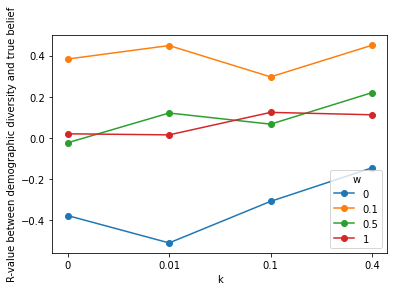

In [27]:
fig, ax = plt.subplots()
K = [0, 0.01, 0.1, 0.4]
e = 0.01

for w in W:
    sub = Brier[(Brier['w']==w)&(Brier['epsilon']==e)]
    data = list(sub['r'])
    ax.plot(data, label=w, marker='o')
plt.xlabel('k')
plt.ylabel('R-value between demographic diversity and true belief')
plt.legend(title='w')
plt.xticks(range(len(K)), K)